In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import pandas as pd
import argparse                 
import sklearn 
import numpy as np 
import logging 
import sklearn.metrics as metrics 
import scikitplot as skplt
import matplotlib.pyplot as plt                                  
from argparse import ArgumentParser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset, random_split
import torch.nn.functional as F
from collections import Counter, defaultdict
import itertools
import os 
import copy
import warnings
from dataload import makedata
from classifier import ClassifierTrainer
from models import VQ_Classifier
import itertools
import random
from scipy import pi
from scipy.fftpack import fft
from torcheval.metrics.aggregation.auc import AUC
from data import load_data
torch.manual_seed(911) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
sample_rate =1
time =  np.linspace(0,sample_rate,16)
freq = 8
magnitude = 0.5

waveform = torch.tensor(magnitude*np.sin(2*pi*freq*time))


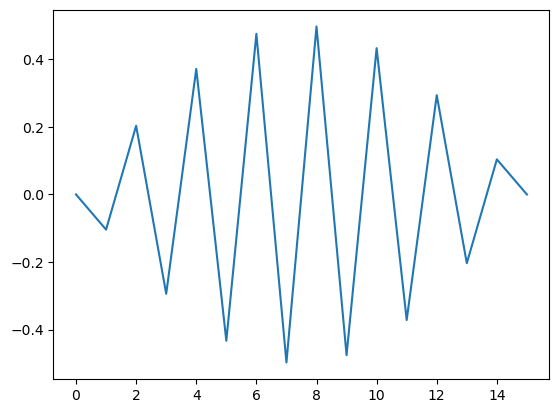

In [13]:
waveform.shape
plt.plot(waveform)

Toy dataset 3
포지션만 다르고 ampliture는 같은 데이터셋
class 0 : amplitude는 왼쪽(0~79)
class 1 : amplitude는 오른쪽(80~192)


In [23]:
class0=[]
freq_class0=[]
N=192
for i in range(1000):
    magnitude = torch.rand(1) / 10
    time =  np.linspace(0,sample_rate,16)
    freq = torch.randint(1,256,(1,))
    sample  = torch.tensor(magnitude*np.sin(2*pi*freq*time)) + 0.5
    sample = torch.cat((sample, torch.zeros(176)),dim=0)
    class0.append(sample)
    
    frequency = np.linspace(0.0, 98, int(N/2))
    freq_data = fft(sample.numpy())
    y = torch.from_numpy(2/N * np.abs(freq_data[0:int(N/2)]))
    freq_class0.append(y)
   
    

b = torch.Tensor(1000,19,1)
class0 = torch.cat(class0, out = b).reshape(1000,192)
freq_class0 = torch.cat(freq_class0, out=b).reshape(1000,96)
torch.save(class0,'/home/smjo/xai_timeseries/data/toydata3_class0.pt')
torch.save(freq_class0, '/home/smjo/xai_timeseries/data/toydata3_class0_freq.pt')

/tmp/ipykernel_102673/1765122208.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample  = torch.tensor(magnitude*np.sin(2*pi*freq*time)) + 0.5


In [24]:
class1=[]
freq_class1=[]
for i in range(1000):
    magnitude = torch.rand(1) / 10
    time =  np.linspace(0,sample_rate,16)
    freq = torch.randint(1,256,(1,))
    sample  = torch.tensor(magnitude*np.sin(2*pi*freq*time)) + 0.5
    sample = torch.cat((torch.zeros(176), sample),dim=0)
    class1.append(sample)

    
    frequency = np.linspace(0.0, sample_rate, int(N/2))
    freq_data = fft(sample.numpy())
    y = torch.from_numpy(2/192 * np.abs(freq_data[0:int(N/2)]))
    freq_class1.append(y)
   
    

b = torch.Tensor(1000,19,1)
class1 = torch.cat(class1, out = b).reshape(1000,192)
freq_class1 = torch.cat(freq_class1, out=b).reshape(1000,96)
torch.save(class1,'/home/smjo/xai_timeseries/data/toydata3_class1.pt')
torch.save(freq_class1, '/home/smjo/xai_timeseries/data/toydata3_class1_freq.pt')

/tmp/ipykernel_102673/1324773505.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample  = torch.tensor(magnitude*np.sin(2*pi*freq*time)) + 0.5


In [25]:
freq_class1.shape

torch.Size([1000, 96])

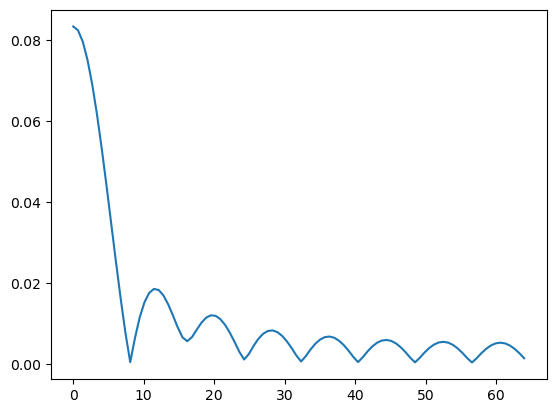

In [26]:
frequency = np.linspace(0.0, sample_rate, int(192/2))
freq_data = fft(sample.numpy())
y = torch.from_numpy(2/192 * np.abs(freq_data[0:int(192/2)]))
plt.plot(frequency,y)

In [27]:
frequency

array([ 0.        ,  0.67368421,  1.34736842,  2.02105263,  2.69473684,
        3.36842105,  4.04210526,  4.71578947,  5.38947368,  6.06315789,
        6.73684211,  7.41052632,  8.08421053,  8.75789474,  9.43157895,
       10.10526316, 10.77894737, 11.45263158, 12.12631579, 12.8       ,
       13.47368421, 14.14736842, 14.82105263, 15.49473684, 16.16842105,
       16.84210526, 17.51578947, 18.18947368, 18.86315789, 19.53684211,
       20.21052632, 20.88421053, 21.55789474, 22.23157895, 22.90526316,
       23.57894737, 24.25263158, 24.92631579, 25.6       , 26.27368421,
       26.94736842, 27.62105263, 28.29473684, 28.96842105, 29.64210526,
       30.31578947, 30.98947368, 31.66315789, 32.33684211, 33.01052632,
       33.68421053, 34.35789474, 35.03157895, 35.70526316, 36.37894737,
       37.05263158, 37.72631579, 38.4       , 39.07368421, 39.74736842,
       40.42105263, 41.09473684, 41.76842105, 42.44210526, 43.11578947,
       43.78947368, 44.46315789, 45.13684211, 45.81052632, 46.48

In [95]:
class1=[]
for i in range(1000):
    magnitude = torch.rand(1) / 10
    time =  np.linspace(0,sample_rate,16)
    freq = torch.randint(1,256,(1,))
    sample  = torch.tensor(magnitude*np.sin(2*pi*freq*time)) + 0.5
    sample = torch.cat((torch.zeros(176), sample),dim=0)
    class1.append(sample)

b = torch.Tensor(1000,19,1)
class1 = torch.cat(class1, out = b).reshape(1000,192)
torch.save(class1,'/home/smjo/xai_timeseries/data/toydata3_class1.pt')

/tmp/ipykernel_48020/1423373318.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample  = torch.tensor(magnitude*np.sin(2*pi*freq*time)) + 0.5


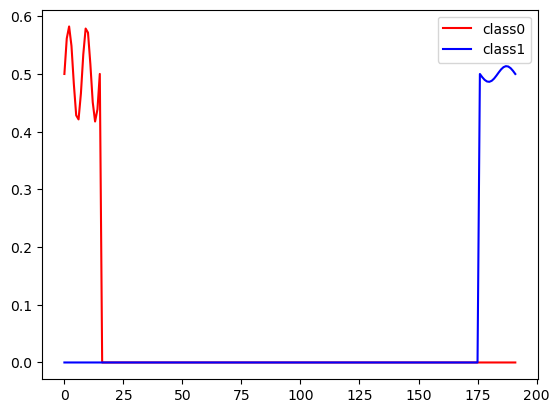

In [93]:
for i in range(1):
    plt.plot(class0[i], 'r', label='class0')
    plt.plot(class1[i],'b', label='class1' )
plt.legend(loc='upper right')
plt.show()

In [48]:
class0 = torch.load('/home/smjo/xai_timeseries/data/toydata3_class0.pt')
class1 = torch.load('/home/smjo/xai_timeseries/data/toydata3_class1.pt')

convert timeseries to furier transform

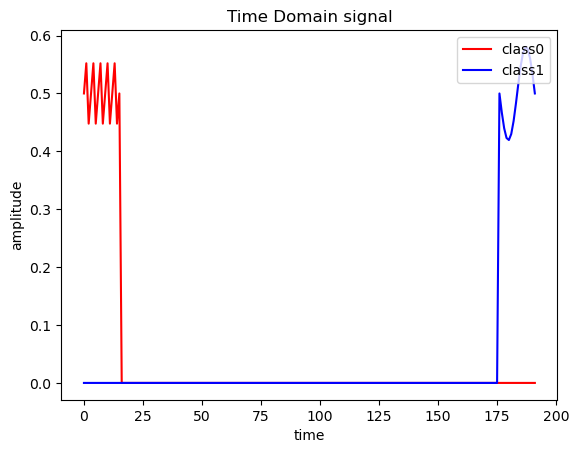

In [51]:
for i in range(1):
    plt.plot(class0[i], 'r', label='class0')
    plt.plot(class1[i],'b', label='class1' )
plt.legend(loc='upper right')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('Time Domain signal')
plt.show()

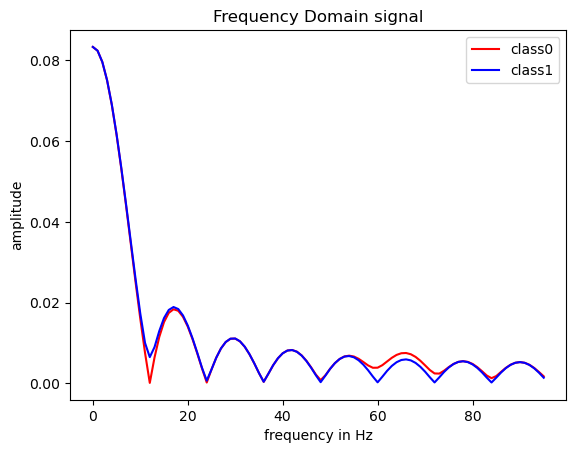

In [52]:
class0_f= torch.load('/home/smjo/xai_timeseries/data/toydata3_class0_freq.pt')
class1_f= torch.load('/home/smjo/xai_timeseries/data/toydata3_class1_freq.pt')
for i in range(1):
    plt.plot(class0_f[i], 'r', label='class0')
    plt.plot(class1_f[i],'b', label='class1' )
plt.legend(loc='upper right')
plt.xlabel('frequency in Hz')
plt.ylabel('amplitude')
plt.title('Frequency Domain signal')
plt.show()

In [26]:
ds =  load_data('toydata3',task='classification', domain='frequency')
batch_size= 256
train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(ds, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, pin_memory=True)


task is classification
dataset is toydata3
X shape:torch.Size([2000, 96]), y shape:torch.Size([2000])
